# Meta Data Preparation
In this notebook, we read in the imaging maps, galaxy catalog, and the bright stars masks. Make healix masks, etc.

#### Read required modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import fitsio as ft
import pandas  as pd
import numpy   as np
import healpy  as hp
import seaborn as sns
import pymangle
from   glob import glob
import sys
from   utils import hpixsum, hpix2radec

camb is not installed!


## Cut objects based on Bright stars masks
#### Q1: Bright stars mask?

In [8]:
sdss  = pymangle.Mangle('/Volumes/TimeMachine/data/bright_object_mask_rykoff_pix.ply')
tych1 = pymangle.Mangle('/Volumes/TimeMachine/data/tycho2mask-0Vmag10.pol')
tych2 = pymangle.Mangle('/Volumes/TimeMachine/data/tycho2mask-10Vmag11.pol')
tych3 = pymangle.Mangle('/Volumes/TimeMachine/data/tycho2mask-11Vmag115.pol')

ra,dec = hpix2radec(256, np.arange(12*256*256))
msdss = sdss.contains(ra,  dec)
mt1   = tych1.contains(ra, dec)
mt2   = tych2.contains(ra, dec)
mt3   = tych3.contains(ra, dec)

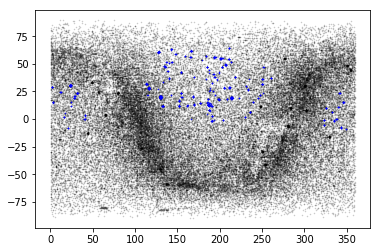

In [10]:
mall = msdss | mt1 | mt2 | mt3
plt.scatter(ra[mall], dec[mall], 1.0, color='k', marker='.', alpha=0.2)
plt.scatter(ra[msdss], dec[msdss], 1.0, color='b', marker='.')

In [11]:
ls /Volumes/TimeMachine/data/DR7/

7.1/                        eBOSS.ELG.NGC.DR7.fits
ccds-annotated-dr7.fits.gz  sysmaps/


In [2]:
def apply_cut(cat_in, cat_out, cat_hp):
    data = ft.read(cat_in, lower=True)
    n = data.size
    print('original cat. size,', data.size)
    # 3760648
    # sdss = pymangle.Mangle('/Volumes/TimeMachine/data/bright_object_mask_rykoff_pix.ply')
    tych1= pymangle.Mangle('/Volumes/TimeMachine/data/tycho2mask-0Vmag10.pol')
    tych2= pymangle.Mangle('/Volumes/TimeMachine/data/tycho2mask-10Vmag11.pol')
    tych3= pymangle.Mangle('/Volumes/TimeMachine/data/tycho2mask-11Vmag115.pol')
    mask = ~data['brightstarinblob']
    # mask &= (data['anymask_g'] == 0) 
    # mask &= (data['anymask_r'] == 0) 
    # mask &= (data['anymask_z'] == 0) 
    data1 = data[mask]
    #print('data size after anymask & brightstarinblob cuts {:.4f} %'.format(data1.size/float(n)))
    print('data size after brightstarinblob cuts {:.4f} %'.format(data1.size/float(n)))
    mask_stars = np.zeros(data1.size, '?')
    for i,smask in enumerate([tych1, tych2, tych3]): #sdss, 
        mask_stars |= smask.contains(data1['ra'], data1['dec'])
        print(i)
    print('# of removed sources due to bright stars {}'.format(mask_stars.sum()))
    data2 = data1[~mask_stars]
    ft.write(cat_out, data2, clobber=True)
    #
    # pixelate
    hpm = hpixsum(256, data2['ra'], data2['dec'])
    hp.write_map(cat_hp, hpm, fits_IDL=False, overwrite=True)
    

apply_cut('/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.fits',
          '/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.cut.fits',
          '/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.cut.hp256.fits')

original cat. size, 3760648
data size after brightstarinblob cuts 0.9542 %
0
1
2
# of removed sources due to bright stars 202712


In [3]:
ls /Volumes/TimeMachine/data/DR7/

7.1/                              eBOSS.ELG.NGC.DR7.table.5.r.npy
DR7meta.h5                        eBOSS.ELG.NGC.DR7.table.fits
ccds-annotated-dr7.fits.gz        frac.hp.256.fits
eBOSS.ELG.NGC.DR7.cut.fits        mask.hp.256.fits
eBOSS.ELG.NGC.DR7.cut.hp256.fits  results/
eBOSS.ELG.NGC.DR7.fits            sysmaps/


## Combine the galaxy density and imaging maps 

In [4]:
def G_to_C(mapi, res_in=1024, res_out=256):
    thph = hp.pix2ang(res_out, np.arange(12*res_out*res_out))
    r = hp.Rotator(coord=['C', 'G'])
    thphg = r(thph[0], thph[1])
    hpix  = hp.ang2pix(res_in, thphg[0], thphg[1])
    return mapi[hpix]

def extract_keys(mapi):
    band = mapi.split('/')[-1].split('_')[3]
    sysn = mapi.split('/')[-1].split('_')[6]
    oper = mapi.split('/')[-1].split('_')[-1].split('.')[0]
    return '_'.join((sysn, band, oper))

def IvarToDepth(ivar):
    """
        function to change IVAR to DEPTH
    """
    depth = nanomaggiesToMag(5./np.sqrt(ivar))
    return depth

def nanomaggiesToMag(nm):
    return -2.5 * (np.log10(nm) - 9.)

def maskmap(filename, nside=256):    
    data   = ft.read(filename, lower=True)
    if 'ivar' in filename:
        print('change ivar to depth ...')
        signal = IvarToDepth(data['signal'])
    elif 'fwhm' in filename:
        print('change fwhm to arcsec ...')
        signal = data['signal']*0.262
    else:
        signal = data['signal']
    #
    output = np.empty(12*nside*nside)
    output.fill(np.nan)
    output[data['pixel']] = signal
    return output

def combine_maps(maps, cat_hp):
    dr7meta = {}
    for mapi in maps:    
        namei  = extract_keys(mapi)    
        print('working on ... %s'%mapi.split('/')[-1])
        if 'ivar' in namei:namei = namei.replace('ivar', 'depth')
        dr7meta[namei] = maskmap(mapi)
    gaia = ft.read('/Volumes/TimeMachine/data/gaia/Gaia.dr2.bGT10.12g17.hp256.fits', lower=True)
    ebv  = hp.read_map('/Volumes/TimeMachine/data/healSFD_256_fullsky.fits', verbose=False)
    dr7meta['nstar'] = gaia['hpstardens'].astype('f8')
    dr7meta['ebv']   = ebv

    # read Lenz et. al. map
    # ebvhd   = ft.read('/Volumes/TimeMachine/data/ebv_lhd.hpx.fits', lower=True)['ebv'].astype('f8')
    # ebvhd_c = G_to_C(ebvhd)
    # nan     = np.isnan(ebvhd_c)
    # ebvhd_m = ebvhd_c.copy()
    # ebvhd_c[nan] = ebv[nan]-.5

    # H II map
    hii = ft.FITS('/Volumes/TimeMachine/data/NHI_HPX.fits', lower=True)
    Hii = hii[1].read()
    neg_mask = (Hii['nhi']<=0.0)
    Hiic = G_to_C(Hii['nhi'])
    Hineg = np.argwhere(Hiic<=0.0).flatten()
    neighbors = hp.get_all_neighbours(256, Hineg)
    Hiic[Hineg] = np.mean(Hiic[neighbors], axis=0) # fill in negative pixels
    #
    #dr7meta['ebv_lenz']      = ebvhd_c
    #dr7meta['ebv_lenz_org']  = ebvhd_m
    #dr7meta['debv_lenz_sfd'] = ebvhd_c-ebv
    dr7meta['logHI'] = np.log(Hiic)
    DR7meta = pd.DataFrame(dr7meta)
    DR7meta['count_min'] = DR7meta[['_'.join(('count',b, 'fracdet')) for b in 'rgz']].min(axis=1) # add min of counts
    #
    # ngal
    hpgal    = hp.read_map(cat_hp, verbose=False)
    DR7meta['ngal'] = hpgal
    #
    # mask
    nanids = np.unique(np.where(DR7meta.isna())[0])
    nonan  = np.ones(12*256*256, '?')
    nonan[nanids] = False
    mask   = (DR7meta['depth_g_total'] >= 22.0) & (DR7meta['depth_z_total']>= 20.5)\
            &(DR7meta['depth_r_total'] >= 21.4) & (DR7meta['count_min']>= 0.2) & nonan
    DR7meta['mask'] = mask
    if len(np.where(DR7meta[DR7meta['mask']].isna())[0]) != 0:print('There is NaNs')
    avg = DR7meta['ngal'].sum()/DR7meta['count_min'].sum()
    # replace inf with nan
    # replace inf with nan
    DR7meta.replace([np.inf, -np.inf], np.nan, inplace=True)
    return DR7meta

In [5]:
maps = glob('/Volumes/TimeMachine/data/DR7/sysmaps/DECaLS_DR7/nside256_oversamp4/DECaLS_DR7_band_*')
maps[0], len(maps)

('/Volumes/TimeMachine/data/DR7/sysmaps/DECaLS_DR7/nside256_oversamp4/DECaLS_DR7_band_g_nside256_oversamp4_ccdskymag__mean.fits.gz',
 24)

In [6]:
DR7meta = combine_maps(maps, '/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.cut.hp256.fits')

working on ... DECaLS_DR7_band_g_nside256_oversamp4_ccdskymag__mean.fits.gz
working on ... DECaLS_DR7_band_g_nside256_oversamp4_count__fracdet.fits.gz
working on ... DECaLS_DR7_band_g_nside256_oversamp4_exptime__total.fits.gz
working on ... DECaLS_DR7_band_g_nside256_oversamp4_fwhm__mean.fits.gz
change fwhm to arcsec ...
working on ... DECaLS_DR7_band_g_nside256_oversamp4_ivar__total.fits.gz
change ivar to depth ...
working on ... DECaLS_DR7_band_g_nside256_oversamp4_mjd_obs__max.fits.gz
working on ... DECaLS_DR7_band_g_nside256_oversamp4_mjd_obs__mean.fits.gz
working on ... DECaLS_DR7_band_g_nside256_oversamp4_mjd_obs__min.fits.gz
working on ... DECaLS_DR7_band_r_nside256_oversamp4_ccdskymag__mean.fits.gz
working on ... DECaLS_DR7_band_r_nside256_oversamp4_count__fracdet.fits.gz
working on ... DECaLS_DR7_band_r_nside256_oversamp4_exptime__total.fits.gz
working on ... DECaLS_DR7_band_r_nside256_oversamp4_fwhm__mean.fits.gz
change fwhm to arcsec ...
working on ... DECaLS_DR7_band_r_nsid

In [7]:
DR7meta.to_hdf('/Volumes/TimeMachine/data/DR7/DR7meta.h5', 'DR7meta', mode='w', format='fixed')

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


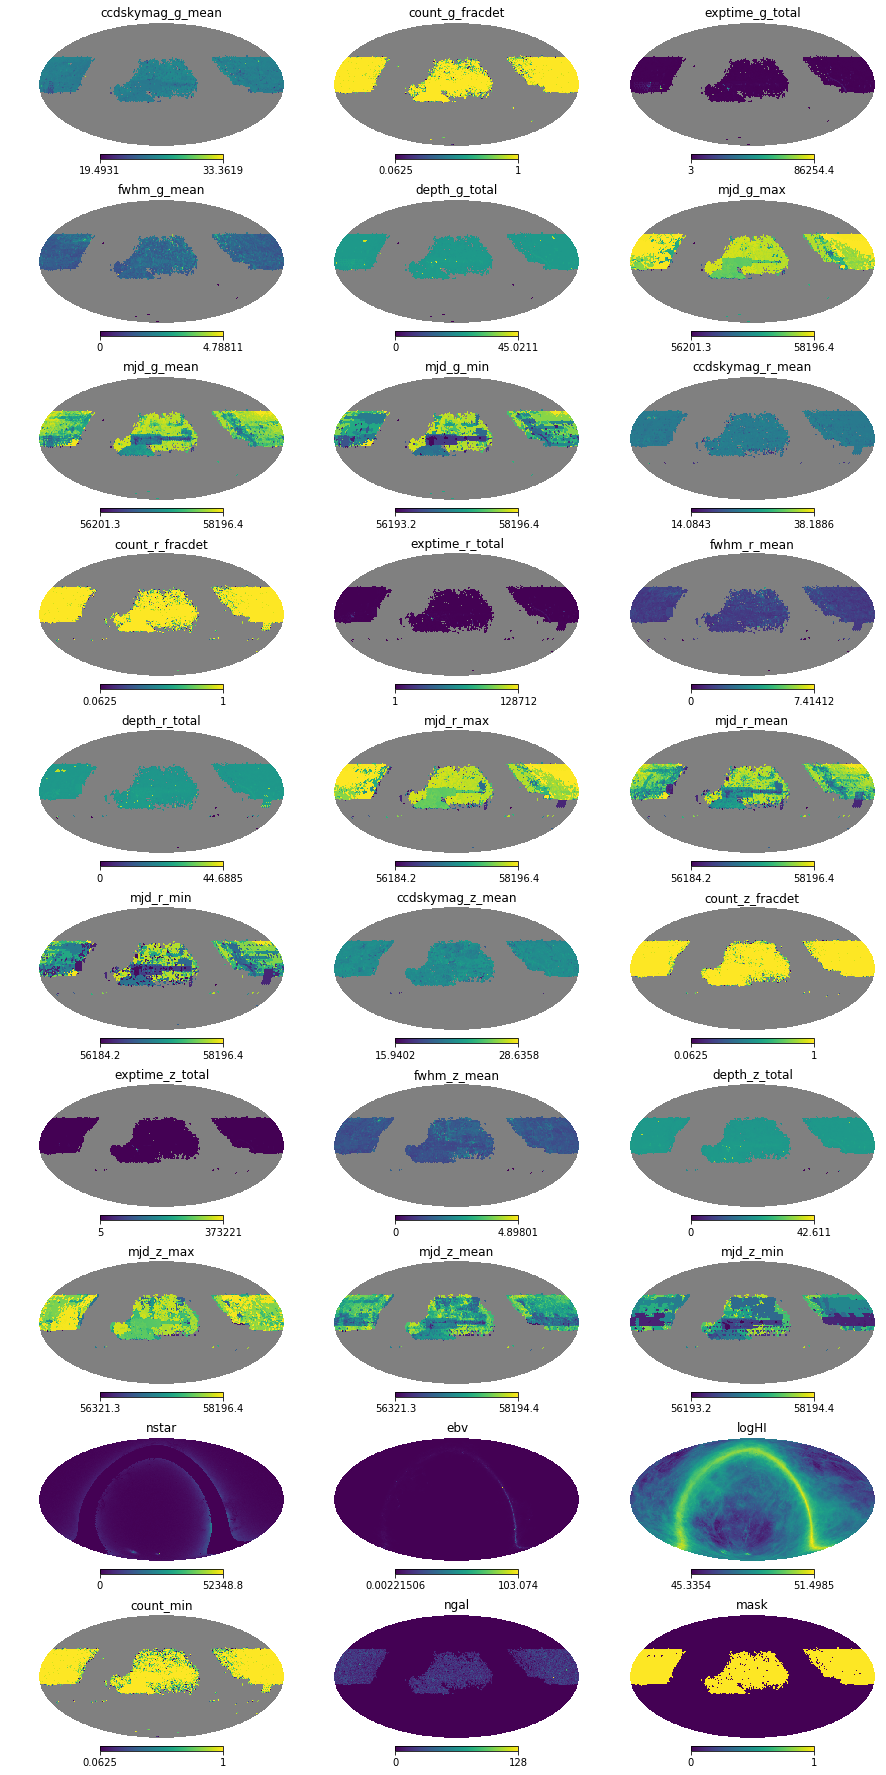

In [8]:
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(15, 32))
ax=ax.flatten()
for i,name in enumerate(DR7meta.columns):
    plt.sca(ax[i])
    hp.mollview(DR7meta[name], hold=True, title=name)

## Read the metadata and write out as a FITS table

In [9]:
def hd5_2_fits(metaname, fitname, hpmask, hpfrac, cols):    
    metadata = pd.read_hdf(metaname)
    features = metadata[cols][metadata['mask']].values    
    hpind    = np.argwhere(metadata['mask']).flatten()
    nbar     = metadata['ngal'][metadata['mask']].sum() / metadata['count_min'][metadata['mask']].sum()
    label    = (metadata['ngal'][metadata['mask']] / metadata['count_min'][metadata['mask']])/nbar
    fracgood = metadata['count_min'][metadata['mask']]  
    
    # for n in metadata.columns:
    #     print('%20s : %d'%(n, np.isnan(metadata[metadata['mask']][n]).sum()))
    outdata = np.zeros(features.shape[0], 
                       dtype=[('label', 'f8'),
                              ('hpind','i8'), 
                              ('features',('f8', features.shape[1])),
                              ('fracgood','f8')])
    outdata['label']    = label
    outdata['hpind']    = hpind
    outdata['features'] = features
    outdata['fracgood'] = fracgood
    #
    #
    ft.write(fitname, outdata, clobber=True)
    print('Average N : %.8f'%nbar)
    #
    # 
    mask = np.zeros(12*256*256, '?')
    mask[hpind] = True
    hp.write_map(hpmask, mask, overwrite=True, fits_IDL=False)
    #
    #
    frac = np.zeros(12*256*256)
    frac[hpind] = fracgood
    hp.write_map(hpfrac, frac, overwrite=True, fits_IDL=False)

In [10]:
cols   = ['ebv','logHI', 'nstar',\
          'depth_r_total', 'depth_g_total', 'depth_z_total',\
         'fwhm_r_mean', 'fwhm_g_mean', 'fwhm_z_mean',\
         'ccdskymag_r_mean', 'ccdskymag_g_mean', 'ccdskymag_z_mean',
         'exptime_r_total', 'exptime_g_total', 'exptime_z_total',
         'mjd_r_min', 'mjd_g_min', 'mjd_z_min'] 
fitname = '/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.table.fits'
metaname = '/Volumes/TimeMachine/data/DR7/DR7meta.h5'
hpmask   = '/Volumes/TimeMachine/data/DR7/mask.hp.256.fits'
hpfrac   = '/Volumes/TimeMachine/data/DR7/frac.hp.256.fits'

# call the function
hd5_2_fits(metaname, fitname, hpmask, hpfrac, cols)

Average N : 18.62259356


## Split the FITS table into Training, Test and Validation sets

In [11]:
from utils import read_split_write

In [13]:
read_split_write('/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.table.fits',
                 '/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.table.5.r.npy',
                 k=5,
                 random=True)

In [14]:
ls -lt /Volumes/TimeMachine/data/DR7/

total 3500224
-rw-r--r--    1 rezaie  staff   194749656 Feb 21 23:10 eBOSS.ELG.NGC.DR7.table.5.r.npy
-rw-r--r--    1 rezaie  staff    31466880 Feb 21 23:09 eBOSS.ELG.NGC.DR7.table.fits
-rw-r--r--    1 rezaie  staff     3153600 Feb 21 23:09 frac.hp.256.fits
-rw-r--r--    1 rezaie  staff     3153600 Feb 21 23:09 mask.hp.256.fits
-rw-r--r--    1 rezaie  staff   189539400 Feb 21 23:06 DR7meta.h5
-rw-r--r--    1 rezaie  staff     3153600 Feb 21 23:03 eBOSS.ELG.NGC.DR7.cut.hp256.fits
-rw-r--r--    1 rezaie  staff   159128640 Feb 21 23:03 eBOSS.ELG.NGC.DR7.cut.fits
drwxr-xr-x    4 rezaie  staff         136 Feb 21 13:38 results/
-rw-r--r--    1 rezaie  staff   176757120 Feb 20 13:51 eBOSS.ELG.NGC.DR7.fits
drwxr-xr-x    3 rezaie  staff         102 Feb 20 10:25 sysmaps/
-rw-r--r--    1 rezaie  staff  1030980268 Feb 11 16:03 ccds-annotated-dr7.fits.gz
drwxr-xr-x  295 rezaie  staff       10030 Aug  6  2018 7.1/


# Split the FITS table for the mock footprint for testing

In [2]:
dt = ft.read('/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.table.fits')
dt.dtype.names

('label', 'hpind', 'features', 'fracgood')

In [5]:
mock = hp.read_map('/Volumes/TimeMachine/data/mocks/mask.hp.256.fits') > 0

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [7]:
data_on_mock = np.in1d(dt['hpind'], np.argwhere(mock).flatten())
data_on_mock.mean()

0.47887128385053696

In [8]:
dt_mock = dt[data_on_mock]
dt_mock.size

89672

In [9]:
from utils import split2Kfolds

In [10]:
dt_mock5 = split2Kfolds(dt_mock)

In [12]:
np.save('/Volumes/TimeMachine/data/DR7/eBOSS.ELG.NGC.DR7.mocks.table.5.r.npy', dt_mock5)